# Imports
**Keras** on **tensorflow** for transfer learning and loading pretrained models, **Sklearn** for post-run metrics, **Pillow** for image management, and others.

In [ ]:
!pip install keras-preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 841.2 kB/s eta 0:00:00


In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # To use local CPU instead of local GPU
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from PIL import Image
import keras,cv2,shutil,keras_preprocessing,requests,math,glob, datetime
import tensorflow as tf
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Lambda, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, SpatialDropout2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocessor
from keras.applications.xception import Xception, preprocess_input as xception_preprocessor
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inc_resnet_preprocessor
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocessor
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_files
from io import BytesIO
import seaborn as sns
import xml.etree.ElementTree as ET
from pathlib import Path
%load_ext tensorboard
shutil.rmtree('./logs', ignore_errors=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Functions and Constants
Functions for plotting results, reading annotations from the dataset and makinga squared image without changing aspect ratio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
dog_images = glob.glob('/content/drive/MyDrive/Images/*/*')
breeds = glob.glob('/content/drive/MyDrive/Annotation/*')
annotations = glob.glob('/content/drive/MyDrive/Annotation/*/*')
cropped = "./Cropped/"
img_size = 299 # For Exception input
train_dir = './Cropped' # './Images'
batch_size_training = 256
batch_size_validation = 256
input_shape = (img_size,img_size,3)

######## Plot Metrics Function ########
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

######## Read X and Y coordinate ranges from an annotation ########
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

######## Get image path from annotation path ########
def get_image(annot):
    img_path = '/content/drive/MyDrive/Images/'
    file = annot.split('/')
    img_filename = img_path + file[-2]+'/'+file[-1]+'.jpg'
    return img_filename

######## Fill image with black to make a square (not used) ########
def make_square(im, min_size=100, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

######## Preprocess and get predictions from data with a pretrained model ########
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = keras.layers.Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    feature_extractor = Model(inputs = input_layer, outputs = GlobalAveragePooling2D()(base_model))
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

######## Concatenate all predictions on data for all pretrained models ########
def extract_all_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, input_shape, data)
    xception_features = get_features(Xception, xception_preprocessor, input_shape, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, input_shape, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, input_shape, data)
    extracted_features = np.concatenate([inception_features, xception_features, nasnet_features, inc_resnet_features],axis=-1)
    return extracted_features

print(len(dog_images), len(breeds), len(annotations))

788 4 788


## Plot a few dogs from the dataset
Aspect ratio will get streched a bit. It produces better results than filling the space needed to resize to square.

<ipython-input-9-8cad99632440>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((100,100), Image.ANTIALIAS)


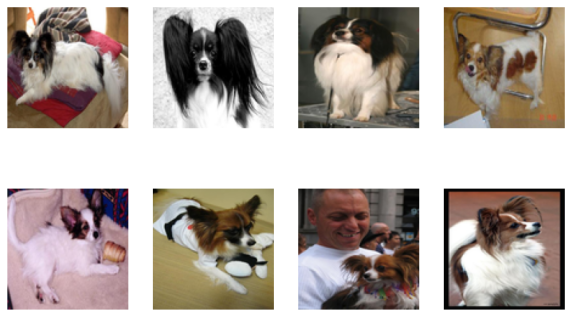

In [ ]:
plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    dog = get_image(annotations[i])
    im = Image.open(dog)
    im = im.resize((100,100), Image.ANTIALIAS)
    plt.imshow(im)

# Crop Dogs From Files
Use bounding box annotations from the dataset in order to crop images. Sometimes extracting more than 1 dog per image.
Cropped files could be moved as permanent input data for this notebook, but I'm leaving it here for academic purposes.

In [ ]:
plt.figure(figsize=(10,6))
for i in range(len(dog_images)):
    bbox = get_bounding_boxes(annotations[i])
    dog = get_image(annotations[i])
    im = Image.open(dog)
    for j in range(len(bbox)):
        im2 = im.crop(bbox[j])
        im2 = im2.resize((331,331), Image.ANTIALIAS)
        new_path = dog.replace('/content/drive/MyDrive/Images/','./drive/MyDrive/Cropped/')
        new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
        im2=im2.convert('RGB')
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        im2.save(new_path)

# Read Dataset
Transformations didn't really improve accuracy that much for this dataset.

In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
import os
import glob
from PIL import Image

output_directory = 'resized'  # Remove the leading '/'
desired_size = (100, 100)
image_files = glob.glob('Cropped/*/*.jpg')
for image_path in image_files:
    img = Image.open(image_path)
    img = img.resize(desired_size, Image.ANTIALIAS)
    relative_path = os.path.relpath(image_path, 'Cropped')  # Calculate relative path based on 'Cropped' directory
    output_path = os.path.join(output_directory, relative_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    img.save(output_path)

print("Resizing and saving complete.")


In [ ]:
img=Image.open('/content/drive/MyDrive/resized/n02085936-Maltese_dog/n02085936_10073-0.jpg')
img.size

(100, 100)

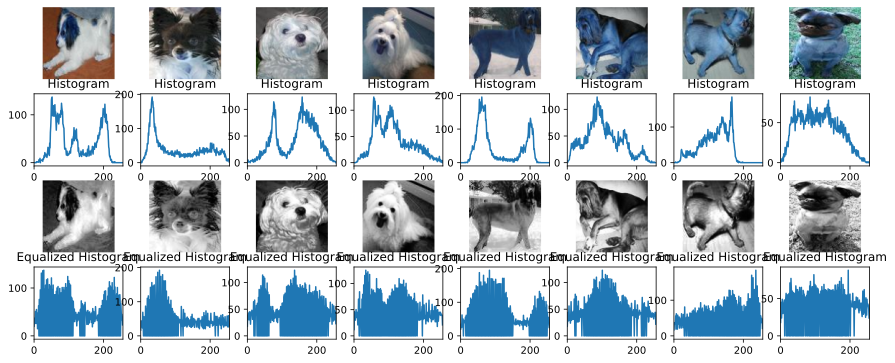

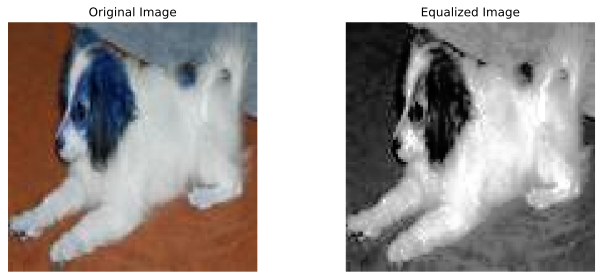

In [ ]:
# Create a function to perform histogram equalization
def histogram_equalization(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray_image)
    return equalized_image

# Initialize lists to store images and histograms
original_images = []
equalized_images = []
original_histograms = []
equalized_histograms = []

# i. Choose 2 images from each class using glob
main_dir = 'resized'  # Main directory containing subfolders
class_dirs = '*'  # Use '*' to match all subdirectories
image_paths = []

class_folders = glob.glob(f'{main_dir}/{class_dirs}')
for class_dir in class_folders:
    class_images = glob.glob(f'{class_dir}/*.jpg')[:2]  # Select the first two images from each class
    image_paths.extend(class_images)

# ii. Convert color images to grayscale images and store histograms
for path in image_paths:
    image = cv2.imread(path)
    original_images.append(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    original_histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    original_histograms.append(original_histogram)

# iii. Plot the 8 grayscale images with their corresponding pixel intensity histograms
plt.figure(figsize=(15, 6))
for i in range(len(image_paths)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(original_images[i], cmap='gray')
    plt.axis('off')
    plt.subplot(4, 8, i + 9)
    plt.plot(original_histograms[i])
    plt.title('Histogram')
    plt.xlim([0, 256])

# iv. Perform histogram equalization and store histograms
for image in original_images:
    equalized_image = histogram_equalization(image)
    equalized_images.append(equalized_image)
    equalized_histogram = cv2.calcHist([equalized_image], [0], None, [256], [0, 256])
    equalized_histograms.append(equalized_histogram)

# Plot the NEW intensity equalized grayscale images and their corresponding equalized pixel intensity histograms
for i in range(len(image_paths)):
    plt.subplot(4, 8, i + 17)
    plt.imshow(equalized_images[i], cmap='gray')
    plt.axis('off')
    plt.subplot(4, 8, i + 25)
    plt.plot(equalized_histograms[i])
    plt.title('Equalized Histogram')
    plt.xlim([0, 256])

# v. Pick a grayscale image and its corresponding equalized image and plot them side by side
selected_image = 0
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_images[selected_image], cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(equalized_images[selected_image], cmap='gray')
plt.title('Equalized Image')
plt.axis('off')
plt.tight_layout()
plt.show()


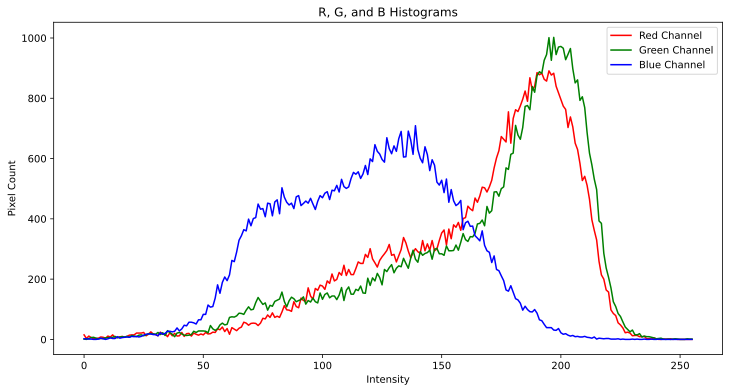

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
from scipy.spatial import distance
from sklearn.decomposition import PCA


image_path = '/content/drive/MyDrive/Images/n02112706-Brabancon_griffon/n02112706_1041.jpg'
image = cv2.imread(image_path)

hist_b = cv2.calcHist([image], [0], None, [256], [0, 256])
hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
hist_r = cv2.calcHist([image], [2], None, [256], [0, 256])

plt.figure(figsize=(12, 6))
plt.plot(hist_r, color='red', label='Red Channel')
plt.plot(hist_g, color='green', label='Green Channel')
plt.plot(hist_b, color='blue', label='Blue Channel')

plt.xlabel('Intensity')
plt.ylabel('Pixel Count')
plt.title('R, G, and B Histograms')
plt.legend()
plt.show()


['resized/n02086910-papillon/n02086910_2410-0.jpg', 'resized/n02086910-papillon/n02086910_2466-0.jpg', 'resized/n02085936-Maltese_dog/n02085936_10073-0.jpg', 'resized/n02086910-papillon/n02086910_2410-0.jpg', 'resized/n02086910-papillon/n02086910_2466-0.jpg', 'resized/n02085936-Maltese_dog/n02085936_10073-0.jpg', 'resized/n02086910-papillon/n02086910_2410-0.jpg', 'resized/n02086910-papillon/n02086910_2466-0.jpg', 'resized/n02085936-Maltese_dog/n02085936_10073-0.jpg', 'resized/n02086910-papillon/n02086910_2410-0.jpg', 'resized/n02086910-papillon/n02086910_2466-0.jpg', 'resized/n02085936-Maltese_dog/n02085936_10073-0.jpg']
Metrics for Images from the Same Class:
Euclidean Distance: 795.0157470703125
Manhattan Distance: 8798.0
Bhattacharyya Distance: 0.4126745590754673
Histogram Intersection: 5601.0

Metrics for Images from Different Classes:
Euclidean Distance: 616.2158813476562
Manhattan Distance: 7160.0
Bhattacharyya Distance: 0.3263645693150165
Histogram Intersection: 6420.0


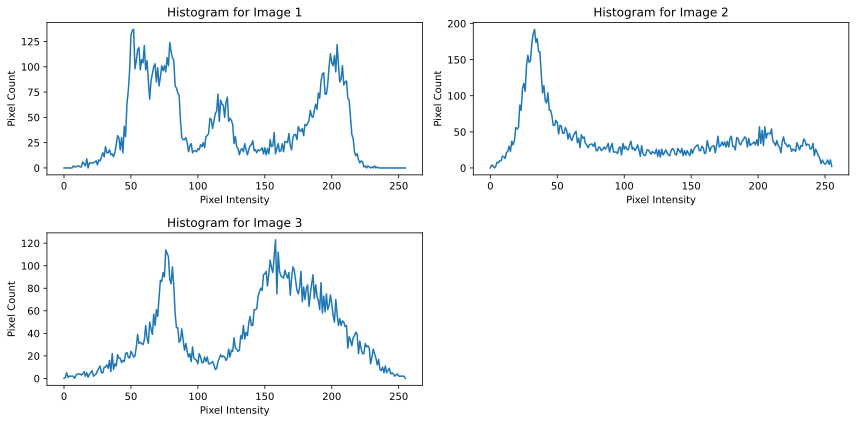

In [ ]:

# Function to calculate histogram for a given image
def calculate_histogram(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    return histogram.flatten()  # Flatten the histogram to make it 1-D

# Initialize lists to store images and histograms
selected_image_paths = []
histograms = []


# Choose 2 images from the same class and 1 image from another class
for i, class_dir in enumerate(class_dirs):
    class_images = glob.glob(f'resized/*/*.jpg')  # Get all images in the current class
    for j in class_images[:2]:
      selected_image_paths.append(j)
    selected_image_paths.append("resized/n02085936-Maltese_dog/n02085936_10073-0.jpg")

print(selected_image_paths)
# Load and process the selected images
for image_path in selected_image_paths:
    image = cv2.imread(image_path)
    histogram = calculate_histogram(image)
    histograms.append(histogram)

euclidean_distance_same_class = distance.euclidean(histograms[0], histograms[1])
manhattan_distance_same_class = distance.cityblock(histograms[0], histograms[1])
bhattacharyya_distance_same_class = cv2.compareHist(histograms[0], histograms[1], cv2.HISTCMP_BHATTACHARYYA)
histogram_intersection_same_class = np.sum(np.minimum(histograms[0], histograms[1]))

euclidean_distance_diff_class = distance.euclidean(histograms[0], histograms[2])
manhattan_distance_diff_class = distance.cityblock(histograms[0], histograms[2])
bhattacharyya_distance_diff_class = cv2.compareHist(histograms[0], histograms[2], cv2.HISTCMP_BHATTACHARYYA)
histogram_intersection_diff_class = np.sum(np.minimum(histograms[0], histograms[2]))

# Display the computed distances
print("Metrics for Images from the Same Class:")
print("Euclidean Distance:", euclidean_distance_same_class)
print("Manhattan Distance:", manhattan_distance_same_class)
print("Bhattacharyya Distance:", bhattacharyya_distance_same_class)
print("Histogram Intersection:", histogram_intersection_same_class)

print("\nMetrics for Images from Different Classes:")
print("Euclidean Distance:", euclidean_distance_diff_class)
print("Manhattan Distance:", manhattan_distance_diff_class)
print("Bhattacharyya Distance:", bhattacharyya_distance_diff_class)
print("Histogram Intersection:", histogram_intersection_diff_class)

# Optionally, you can plot the histograms for visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(histograms[0])
plt.title("Histogram for Image 1")
plt.xlabel("Pixel Intensity")
plt.ylabel("Pixel Count")

plt.subplot(2, 2, 2)
plt.plot(histograms[1])
plt.title("Histogram for Image 2")
plt.xlabel("Pixel Intensity")
plt.ylabel("Pixel Count")

plt.subplot(2, 2, 3)
plt.plot(histograms[2])
plt.title("Histogram for Image 3")
plt.xlabel("Pixel Intensity")
plt.ylabel("Pixel Count")

plt.tight_layout()
plt.show()


Number of Keypoints Extracted: 12


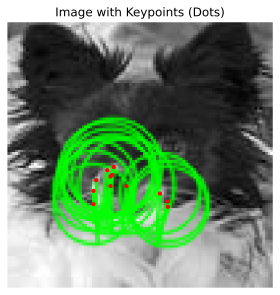

In [ ]:

# Load the image
image_path = selected_image_paths[1] # Replace with the path to your image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Set ORB parameters
edge_threshold = 30
patch_size = 30

# Create an ORB object
orb = cv2.ORB_create(
    edgeThreshold=edge_threshold,
    patchSize=patch_size,
    nlevels=8,
    fastThreshold=20,
    scaleFactor=1.2,
    WTA_K=2,
    scoreType=cv2.ORB_HARRIS_SCORE,
    firstLevel=0,
    nfeatures=30
)

# Find keypoints using ORB
kp = orb.detect(img, None)
img_with_keypoints = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
num_keypoints = len(kp)
print(f"Number of Keypoints Extracted: {num_keypoints}")

for point in kp:
    x, y = point.pt
    plt.scatter(x, y, s=10, c='red', marker='o')

plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Image with Keypoints (Dots)')
plt.show()


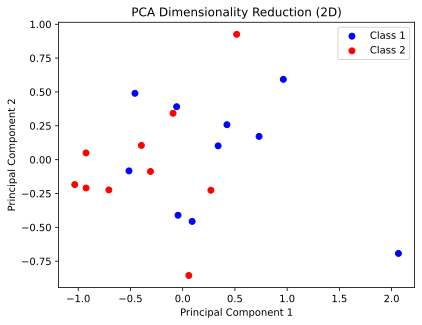

In [ ]:
# Function to calculate histogram for a given image
def calculate_histogram(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    return histogram.flatten()  # Flatten the histogram to make it 1-D

# Initialize lists to store histograms
histograms = []

# Choose images from two different classes
class1_images = glob.glob('resized/n02085936-Maltese_dog/*.jpg')[:10]
class2_images = glob.glob('resized/n02086910-papillon/*.jpg')[:10]

if not class1_images or not class2_images:
    print("No images found in the specified directories.")
else:
    # Load and process the images
    for image_path in class1_images + class2_images:
        image = cv2.imread(image_path)
        histogram = calculate_histogram(image)
        histograms.append(histogram)

    if not histograms:
        print("No histograms calculated.")
    else:
        # Convert the list of histograms to a numpy array and normalize the dataset
        histograms = np.array(histograms)
        histograms = histograms / histograms.max()

        # Perform PCA dimensionality reduction to 2 dimensions
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(histograms)

        # Separate the PCA results into two classes
        pca_class1 = pca_result[:len(class1_images)]
        pca_class2 = pca_result[len(class1_images):]

        # Plot the 2D points with different colors for the two classes
        plt.scatter(pca_class1[:, 0], pca_class1[:, 1], label='Class 1', color='blue')
        plt.scatter(pca_class2[:, 0], pca_class2[:, 1], label='Class 2', color='red')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.title('PCA Dimensionality Reduction (2D)')
        plt.show()


In [ ]:
######## IMAGEDATAGENERATOR ########
train_datagen = ImageDataGenerator(rescale=1./255,
    # rotation_range=0.2,
    # horizontal_flip=True,
    # zoom_range=0.1,
    validation_split=0.2
    )

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

######## FLOW FROM DIRECTORY - TRAINING ########
train_generator = train_datagen.flow_from_directory(
    train_dir,
    seed=42,
    target_size=(img_size, img_size),
    batch_size=batch_size_training,
    subset = 'training',
    class_mode='categorical')

######## FLOW FROM DIRECTORY - VALIDATION ########
validation_generator = valid_datagen.flow_from_directory(
    train_dir,
    seed=42,
    target_size=(img_size, img_size),
    batch_size=batch_size_validation,
    subset = 'validation',
    class_mode='categorical')

num_classes = len(np.unique(train_generator.classes))

# Part I: Load Pretrained (Exception)

In [ ]:
img=Image.open('/content/drive/MyDrive/Images/n02085936-Maltese_dog/n02085936_10073.jpg')
img.size

In [ ]:
inputs = keras.Input(shape=input_shape)

######## LOAD PRETRAINED MODEL ########
base_model = keras.applications.Xception(
    weights = 'imagenet',
    input_shape=input_shape,
    include_top=False)
base_model.trainable = False

######## ADD NEW LAYERS TO PRETRAINED MODEL #########
x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = keras.Model(base_model.input, outputs)
for layer in base_model.layers: layer.trainable = False
#model.summary()

# Train Model (Xception based)

In [ ]:
%%time

######### OPTIMIZER DEFINITION #########
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=5e-2,
#     decay_steps=batch_size_training // 8,
#     decay_rate=0.95)
optimizer = keras.optimizers.Adam(learning_rate=1e-2, epsilon=1e-1)

######### MODEL COMPILATION #########
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

######### CALLBACKS #########
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='./model-{epoch:02d}-{val_accuracy:.4f}.keras', save_best_only=True, monitor='val_accuracy', mode='max')
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stoppage_callback = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001, patience=7, restore_best_weights = True)

######### TRAIN MODEL #########
history = model.fit(train_generator,
            steps_per_epoch = math.ceil(train_generator.samples / batch_size_training),
            epochs=50,
            verbose=1,
            validation_data=validation_generator,
            validation_steps = math.ceil(validation_generator.samples / batch_size_validation),
            callbacks=[tensorboard_callback,early_stoppage_callback,checkpoint_callback]
            )

# Plot Analytics

In [ ]:
plot_metric(history, "loss")
plot_metric(history, "accuracy")

# Validation testing

In [ ]:
preds = model.predict(validation_generator,validation_generator.samples // batch_size_validation)
preds_cls_idx = preds.argmax(axis=-1)
score = model.evaluate(validation_generator)
score

# Googled Dogs Testing (Xception Model)

In [ ]:
urls=[]
urls.append("https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*")
urls.append("https://www.loveyourdog.com/wp-content/uploads/2019/04/Toy-Poodle-900x500.jpg")
urls.append("https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg")
urls.append("https://media.npr.org/assets/img/2013/10/15/pitbull_wide-d1e276d7fe3844b00737f9f2bec97f5920e74626.jpg?s=1400")
for url in urls:
    googled_dog = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
    googled_dog = googled_dog.resize((img_size,img_size), Image.ANTIALIAS)
    display(googled_dog)
    googled_dog = np.asarray(googled_dog)/255
    googled_dog = googled_dog.reshape(1,img_size,img_size,3)
    predicted_dog = model.predict(googled_dog)
    predictedindex = predicted_dog.argmax(axis=-1)
    my_dict = train_generator.class_indices
    print('Prediction:', list(my_dict.keys())[list(my_dict.values()).index(predictedindex)])
    print('Percentage:', '{0:.2f}'.format(float(predicted_dog[0][predictedindex]*100)), '%')

Too bad Pitbull not a pitbull...

# Part II: Stacking Multiple Pretrained Models
* ## Exception
* ## InceptionV3
* ## NasNet
* ## Inception Resnet

For more information on stacking pretrained models, visit:
* https://www.oreilly.com/content/transfer-learning-from-multiple-pre-trained-computer-vision-models/
* https://www.kaggle.com/deepakat002/inception-xception-nasnetlarge-inceptionres
* https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/


In [ ]:
img_size = 331 # Largest input requirement
input_shape = (img_size,img_size,3)
######## IMAGEDATAGENERATOR ########
full_datagen = ImageDataGenerator()
######## FLOW FROM DIRECTORY - TRAINING ########
full_generator = full_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),

    # Had to only send 2500 samples, because of kaggle memory constraints. Should probably fix later to consume less ram or process in batches.
    # Accuracy results are very similar to a full batch local run nonetheless.
    batch_size= 2500, # 22126,#<--- full size
    class_mode='categorical')
num_classes = len(np.unique(full_generator.classes))

In [ ]:
######## Dump dataset into X and y, then split ########
X,y = next(full_generator)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract Features

In [ ]:
final_features_train = extract_all_features(X_train)
final_features_test = extract_all_features(X_test)
print('Final feature maps shape', final_features_train.shape)
print('Final test feature maps shape', final_features_test.shape)

# Run Meta-Learner Model
"Meta-learning in machine learning refers to learning algorithms that learn from other learning algorithms." - https://machinelearningmastery.com/meta-learning-in-machine-learning/

In [ ]:
model = Sequential()
model.add(Dropout(0.5,input_shape=(final_features_train.shape[1],)))
model.add(Dense(num_classes,activation= 'softmax'))

######### OPTIMIZER DEFINITION #########
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

######### CALLBACKS #########
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='./model-{epoch:02d}-{val_accuracy:.4f}.keras', save_best_only=True, monitor='val_accuracy', mode='max')
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stoppage_callback = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001, patience=10, restore_best_weights = True)

######### MODEL COMPILATION #########
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

######### TRAIN MODEL #########
history = model.fit(final_features_train, y_train,
            batch_size=256,
            epochs=50,
            validation_data=(final_features_test,y_test),
            callbacks=[tensorboard_callback,early_stoppage_callback,checkpoint_callback]
            )

# Stacked Model Analytics

In [ ]:
plot_metric(history, "loss")
plot_metric(history, "accuracy")

In [ ]:
y_pred = model.predict(final_features_test)
preds_cls_idx = y_pred.argmax(axis=-1)
y_tests_cls_idx = y_test.argmax(axis=-1)
score = model.evaluate(final_features_test,y_test)
score

In [ ]:
plt.figure(figsize = (10,10))
print('Confusion Matrix')
sns.heatmap(confusion_matrix(y_tests_cls_idx, preds_cls_idx))
#print('Classification Report')
#print(classification_report(y_tests_cls_idx, preds_cls_idx))

# Googled Dogs Testing (Stacked Model)

In [ ]:
urls=[]
urls.append("https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*")
urls.append("https://www.loveyourdog.com/wp-content/uploads/2019/04/Toy-Poodle-900x500.jpg")
urls.append("https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg")
urls.append("https://media.npr.org/assets/img/2013/10/15/pitbull_wide-d1e276d7fe3844b00737f9f2bec97f5920e74626.jpg?s=1400")
for url in urls:
    googled_dog = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
    googled_dog = googled_dog.resize((img_size,img_size), Image.ANTIALIAS)
    display(googled_dog)
    googled_dog = np.asarray(googled_dog).reshape(1,img_size,img_size,3)
    googled_dog=extract_all_features(googled_dog)
    predicted_dog = model.predict(googled_dog)
    predictedindex = predicted_dog.argmax(axis=-1)
    my_dict = full_generator.class_indices
    print('Prediction:', list(my_dict.keys())[list(my_dict.values()).index(predictedindex)])
    print('Percentage:', '{0:.2f}'.format(float(predicted_dog[0][predictedindex]*100)), '%')